In [1]:
#%matplotlib notebook

import numpy as np                                 #Biblioteka obliczeniowa
import pandas as pd
import matplotlib.pyplot as plt                    #Biblioteka wyświetlająca grafy
import matplotlib.colors as mc                     #Biblioteka do zarządzania kolorami zdefiniowanymi w matlotlib 
from colorsys import rgb_to_hls, hls_to_rgb        #Funkcje pozwalające konwertować zapis koloru między formatami RGB i HLS 
from matplotlib.animation import FuncAnimation     #Funkcja umożliwiający animowanie grafu

In [2]:
def darken_color(color, amount=1.5):
    """
    Funkcja zmieniająca jasność zadanego w pierwszym parametrze koloru o stopień
    zadany w drugim parametrze.
    Kolor podawany jest w postaci trójki (R, G, B) reprezentującej
    format RGB lub jako string (słowny lub w formacie #RGB) reprezentujący kolor w bibliotece matplotlib. 
    Współczynnik o wartości < 1.0 rozjaśnia, dla > 1.0 pociemnia.
    Zwracany jest kolor w postaci trójki (R,G,B)
    """
    
    #Konwersja możliwego słownego przedstawienia koloru w format RGB
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = rgb_to_hls(*mc.to_rgb(c))
    
    #Zabezpieczenie utrzymujące wartość nasycenia w przedziale [0,100]
    temp = 1 - amount * (1 - c[1])
    temp = temp if 0 <= temp <= 100 else 0 
    
    c = hls_to_rgb(c[0], temp , c[2])
    return c

In [3]:
class Particle:
    """
    Klasa reprezentująca jedną cząsteczkę. 
    Parametrami początkowymi są pozycja początkowa podawana pod postacią
    dwójki (float, float) oraz długości kroku domyślnie równego 1.
    Klasa poddawana iterowaniu zwraca kolejne pozycje cząsteczki, której
    ruch polega na wykonaniu kroku o zadanej długości w losowym kierunku
    z przedziału [0, 2pi].
    Obiekt tej klasy można wywołać z parametrem liczby naturalnej n, ograniczając
    w rezultacie ilość iteracji do zadanej liczby.
    Obiekt bez uprzedniego wywołania z parametrem n wykonuje się domyślnie 10 razy.
    """
    
    def __init__(self, startpos, steplen = 1):
        self.startpos = startpos
        self.pos = startpos
        self.len = steplen
        self.dist = 0
        self.iterlimit = 10
        self.itercount = 0
        
    def __iter__(self):
        self.itercount = 0
        return self
        
    def __call__(self, n):
        self.iterlimit = n if n > 0 else self.iterlimit
        return self
    
    def __next__(self):
        phi = np.random.uniform(low=0.0, high=2*np.pi)
        newpos = (self.pos[0] + self.len*np.cos(phi), self.pos[1] + self.len*np.sin(phi))
        self.pos = newpos
        
        a,b = self.startpos
        self.dist = np.sqrt((a-newpos[0])**2 + (b-newpos[1])**2)
        if self.itercount >= self.iterlimit:
            raise StopIteration
        self.itercount += 1
        return (self.pos, self.dist)
            
    def currentpos(self):
        """
        Funkcja publiczna zwracająca aktualną pozycję cząsteczki.
        """
        return self.pos
    
    def currentdist(self):
        """
        Funkcja publiczna zwracająca aktualną odległość cząsteczki od punktu startowego.
        """
        return self.dist
    
    def reset(self):
        """
        Funkcja resetująca pozycję, dystans, aktualny krok i limit iteracji do wartości początkowych.
        """
        self.pos = self.startpos
        self.dist = 0
        self.iterlimit = 10
        self.itercount = 0
        return self

<IPython.core.display.Javascript object>


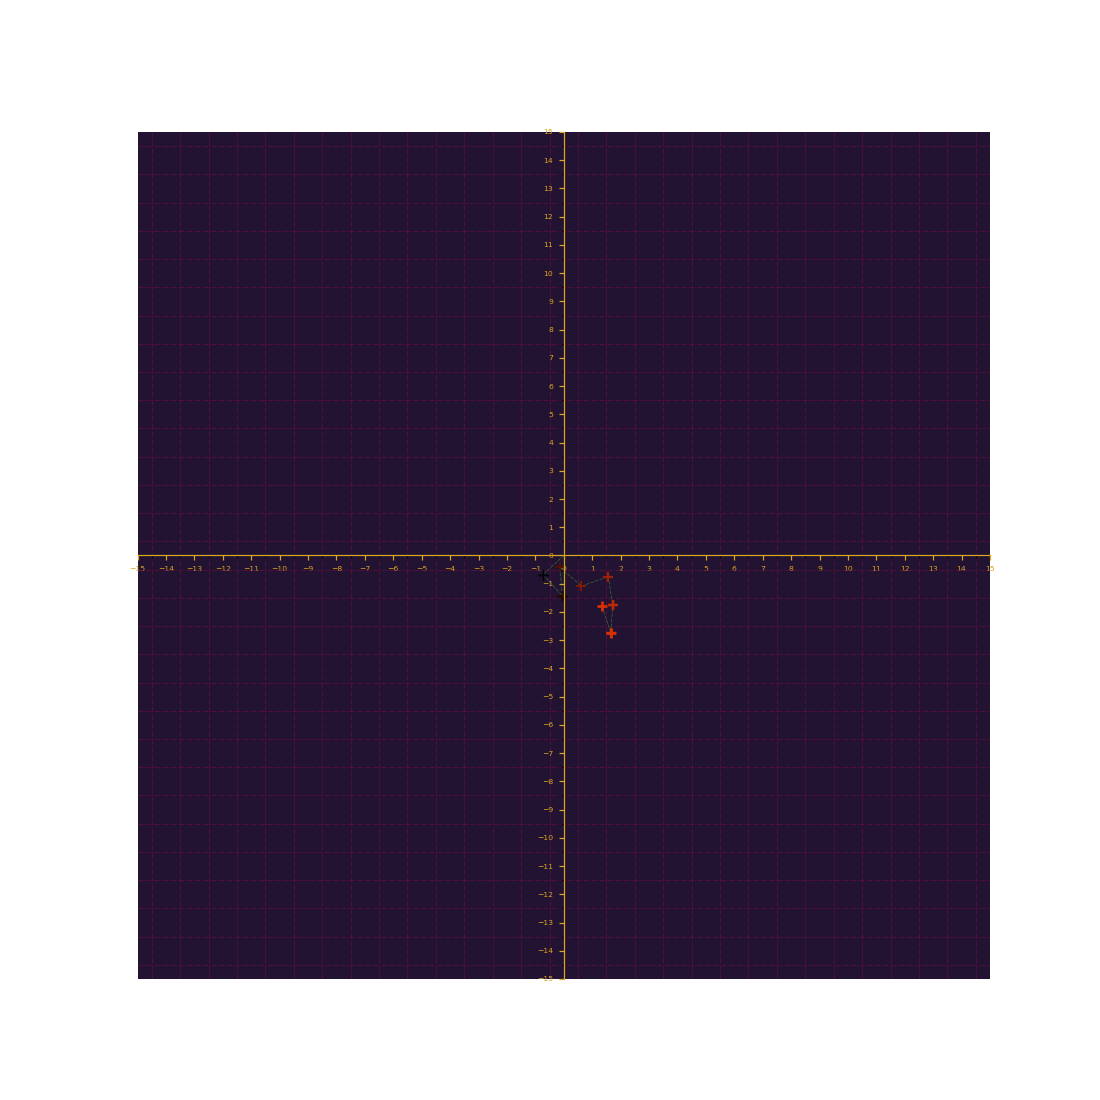

In [26]:
GRIDSIZE = 1    #Stała rozmiaru kratownicy.
SIZE = 10       #Stała długości osi (w jednym kierunku).

#Parametry graficzne kratownicy
gridprop     = {'color' : '#610f39',              
                'linestyle' : '-.',
                'linewidth' : 0.5}

#Parametry graficzne cząsteczki
particleprop = {'color' : '#34a33f',              
                'linestyle' : '-.',
                'linewidth' : 0.3,
                'marker' : '+',
                'markeredgecolor' : '#f03607',
                'markeredgewidth' : 2}

axcolor = '#DAA520'     #Kolor osi
bkgcolor = '#221333'    #Kolor tła

ticks = np.around(np.arange(-SIZE, SIZE+0.1, GRIDSIZE), 0)
minorticks = (ticks+GRIDSIZE/2)[:-1]

fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)

#Ustawienia podziałek
ax.tick_params(labelsize=5, colors = axcolor)
ax.set_yticks(ticks, minor=False)
ax.set_yticks(minorticks, minor=True)
ax.set_xticks(ticks, minor=False)
ax.set_xticks(minorticks, minor=True)

#Ustawienia kratownicy
ax.yaxis.grid(True, which='minor', **gridprop)
ax.xaxis.grid(True, which='minor', **gridprop)

#Ustawienia osi
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['bottom'].set_color(axcolor)
ax.spines['left'].set_position(('data', 0))
ax.spines['left'].set_color(axcolor)

ax.set_facecolor(bkgcolor)    #Ustawienie tła

#Zdefiniowanie i iteracja obiektu klasy Particle
Particle_one = Particle((0,0),1)
partpos = [Particle_one.currentpos()] + [info[0] for info in Particle_one(50)]
xdata, ydata = [], []
steps = [plt.plot([], [], **particleprop)[0] for _ in partpos]    #Generowanie grafów na każdy krok cząsteczki

def init():
    ax.set_xlim(-SIZE-0.2, SIZE+0.2)
    ax.set_ylim(-SIZE-0.2, SIZE+0.2)
    return steps

def update(frame):
    xdata.append(frame[0])
    ydata.append(frame[1])
    for idx in range(len(xdata), 1, -1):
        steps[idx].set_data(xdata[idx-2:idx], ydata[idx-2:idx])
        newcol = darken_color(steps[idx].get_markeredgecolor(), 1.1)
        steps[idx].set_markeredgecolor(newcol)
        
        newwidth = steps[idx].get_markeredgewidth()*0.9
        steps[idx].set_markeredgewidth(newwidth)
    return steps

ani = FuncAnimation(fig, update, frames=partpos,
                    init_func=init, blit=True, repeat=False)
plt.show()

In [44]:
Particle_two = Particle((0,0), 1)
temp = []
for _ in range(100):
    temp.append([info[1] for info in Particle_two(100)])
    Particle_two.reset()
dataframe = pd.DataFrame(np.matrix(temp).T)

dataframe['max'] = dataframe.max(axis=1)
dataframe['med'] = dataframe.median(axis=1)
dataframe['min'] = dataframe.min(axis=1)
dataframe['avg'] = dataframe.mean(axis=1)
dataframe['std'] = dataframe.std(axis=1)

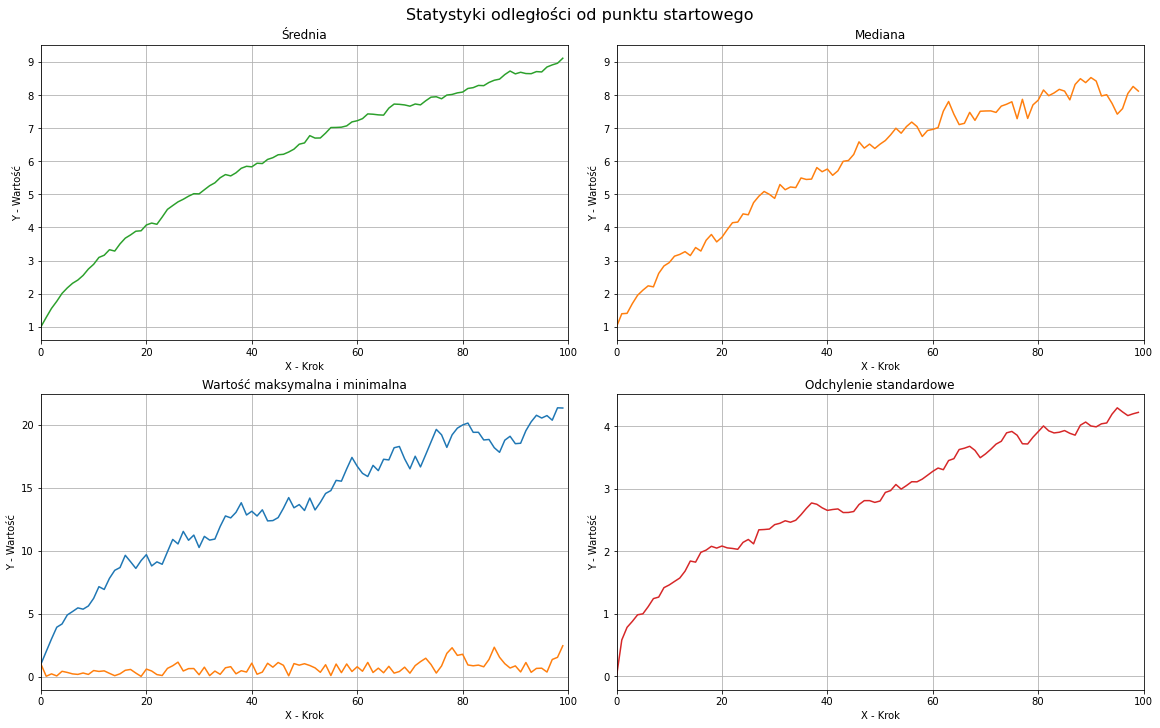

In [45]:
fig2, axs = plt.subplots(2, 2, figsize=(16,10), constrained_layout=True)

axs[1, 0].plot(dataframe['max'])
axs[1, 0].plot(dataframe['min'])
axs[1, 0].set_title('Wartość maksymalna i minimalna')
axs[0, 1].plot(dataframe['med'], 'tab:orange')
axs[0, 1].sharey(axs[0, 0])
axs[0, 1].set_title('Mediana')
axs[0, 0].plot(dataframe['avg'], 'tab:green')
axs[0, 0].set_title('Średnia')
axs[1, 1].plot(dataframe['std'], 'tab:red')
axs[1, 1].set_title('Odchylenie standardowe')

fig2.suptitle('Statystyki odległości od punktu startowego', fontsize=16)

for ax in axs.flat:
    ax.set_xlim(0, 100)
    ax.yaxis.grid(True, which='major')
    ax.xaxis.grid(True, which='major')
    ax.set(xlabel='X - Krok', ylabel='Y - Wartość')

In [75]:
Particle_three = Particle((0,0), 1)
temp = []
for _ in range(100):
    temp.append([info[1] for info in Particle_three(1000)])
    Particle_three.reset()
dataframe = pd.DataFrame(np.matrix(temp).T)

dataframe['max'] = dataframe.max(axis=1)
dataframe['med'] = dataframe.median(axis=1)
dataframe['min'] = dataframe.min(axis=1)
dataframe['avg'] = dataframe.mean(axis=1)
dataframe['std'] = dataframe.std(axis=1)

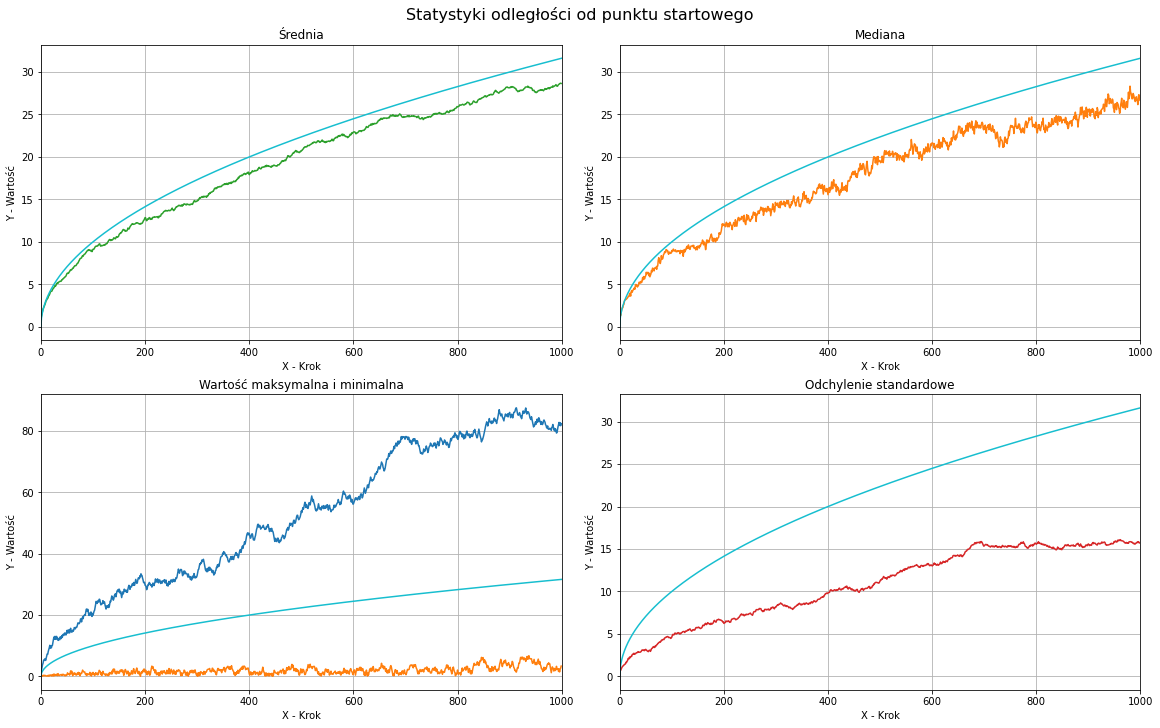

In [76]:
fig3, axs = plt.subplots(2, 2, figsize=(16,10), constrained_layout=True)

axs[1, 0].plot(dataframe['max'])
axs[1, 0].plot(dataframe['min'])
axs[1, 0].set_title('Wartość maksymalna i minimalna')
axs[0, 1].plot(dataframe['med'], 'tab:orange')
axs[0, 1].sharey(axs[0, 0])
axs[0, 1].set_title('Mediana')
axs[0, 0].plot(dataframe['avg'], 'tab:green')
axs[0, 0].set_title('Średnia')
axs[1, 1].plot(dataframe['std'], 'tab:red')
axs[1, 1].set_title('Odchylenie standardowe')

fig3.suptitle('Statystyki odległości od punktu startowego', fontsize=16)

X = list(range(1001))

for ax in axs.flat:
    ax.plot(X,np.sqrt(X), 'tab:cyan')
    ax.set_xlim(0, 1000)
    ax.yaxis.grid(True, which='major')
    ax.xaxis.grid(True, which='major')
    ax.set(xlabel='X - Krok', ylabel='Y - Wartość')

In [77]:
dataframe = dataframe.iloc[:,:-5]**2
dataframe['max'] = dataframe.max(axis=1)
dataframe['med'] = dataframe.median(axis=1)
dataframe['min'] = dataframe.min(axis=1)
dataframe['avg'] = dataframe.mean(axis=1)
dataframe['std'] = dataframe.std(axis=1)

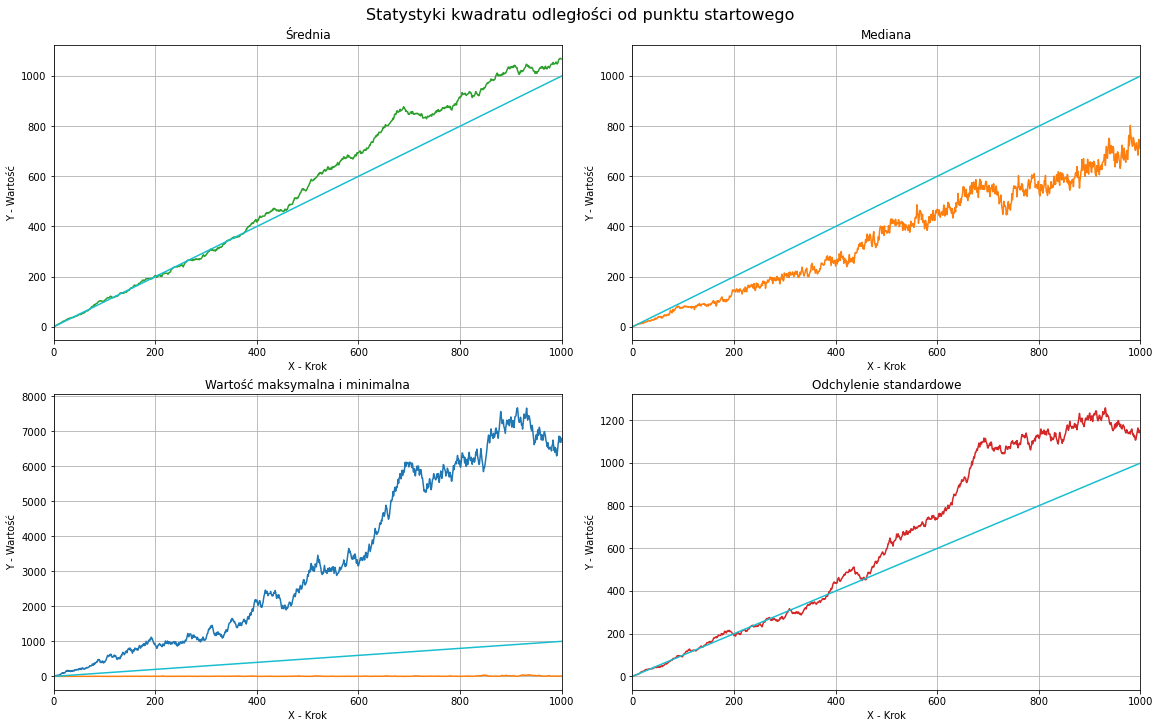

In [78]:
fig4, axs = plt.subplots(2, 2, figsize=(16,10), constrained_layout=True)

axs[1, 0].plot(dataframe['max'])
axs[1, 0].plot(dataframe['min'])
axs[1, 0].set_title('Wartość maksymalna i minimalna')
axs[0, 1].plot(dataframe['med'], 'tab:orange')
axs[0, 1].sharey(axs[0, 0])
axs[0, 1].set_title('Mediana')
axs[0, 0].plot(dataframe['avg'], 'tab:green')
axs[0, 0].set_title('Średnia')
axs[1, 1].plot(dataframe['std'], 'tab:red')
axs[1, 1].set_title('Odchylenie standardowe')

fig4.suptitle('Statystyki kwadratu odległości od punktu startowego', fontsize=16)

for ax in axs.flat:
    ax.plot(X,X, 'tab:cyan')
    ax.set_xlim(0, 1000)
    ax.yaxis.grid(True, which='major')
    ax.xaxis.grid(True, which='major')
    ax.set(xlabel='X - Krok', ylabel='Y - Wartość')

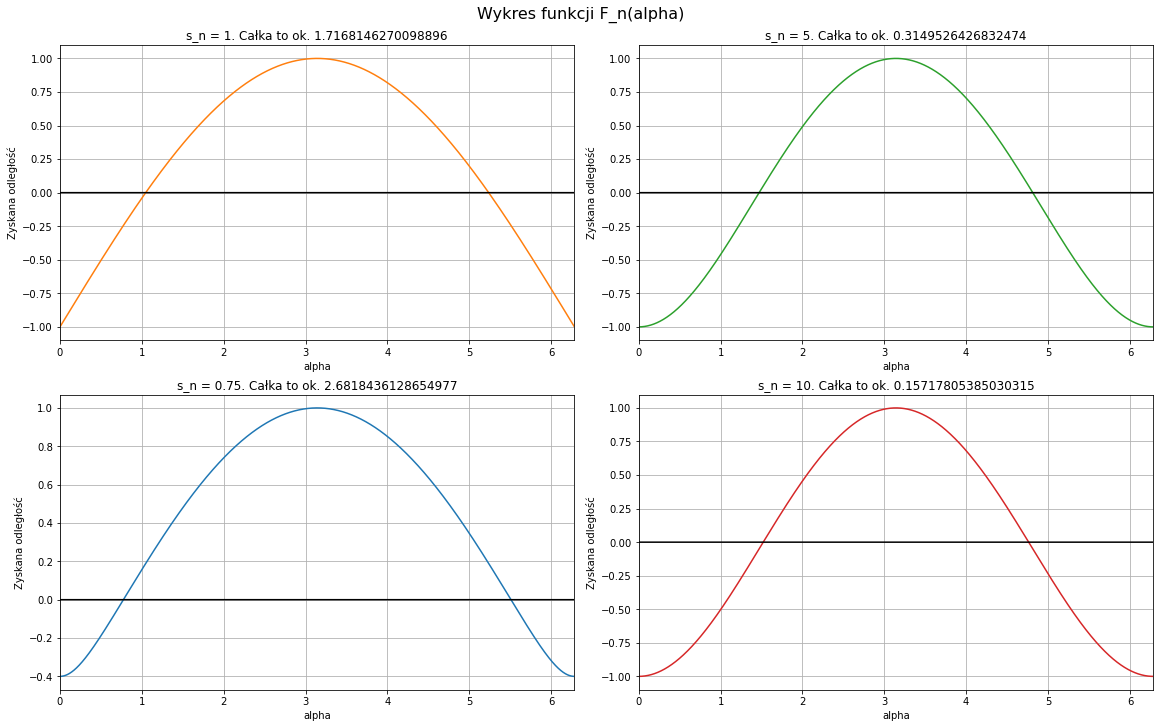

In [99]:
fig5, axs = plt.subplots(2, 2, figsize=(16,10), constrained_layout=True)

def F(s,x):
    return np.sqrt(s**2 - 2*s*np.cos(x)+1)-s
X = np.linspace(0, 2*np.pi, 10000)

axs[0, 0].plot(X,F(1,X), 'tab:orange')
axs[0, 0].set_title(f's_n = 1. Całka to ok. {np.trapz(F(1,X), X,dx=0.001)}')
axs[0, 1].plot(X,F(5,X),'tab:green')
axs[0, 1].set_title(f's_n = 5. Całka to ok. {np.trapz(F(5,X),X,dx=0.001)}')
axs[1, 0].plot(X,F(0.7,X), 'tab:blue')
axs[1, 0].set_title(f's_n = 0.75. Całka to ok. {np.trapz(F(0.7,X), X,dx=0.001)}')
axs[1, 1].plot(X,F(10,X), 'tab:red')
axs[1, 1].set_title(f's_n = 10. Całka to ok. {np.trapz(F(10,X), X ,dx=0.001)}')

fig5.suptitle('Wykres funkcji F_n(alpha)', fontsize=16)

for ax in axs.flat:
    ax.plot(X,[0 for _ in range(10000)], 'k-')
    ax.set_xlim(0, 2*np.pi)
    ax.yaxis.grid(True, which='major')
    ax.xaxis.grid(True, which='major')
    ax.set(xlabel='alpha', ylabel='Zyskana odległość')